### EDA
Notebook to explore data set, filter for clustering, and visualizations to aid in clustering

In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath('..'))
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import src.processing.data_processor as dp

In [6]:
processor = dp.UFCDataProcessor('../data/raw/')
df = processor.process_data()

INFO:src.processing.data_processor:DataProcessor initialized with data path: ../data/raw/
INFO:src.processing.data_processor:Starting simplified processing pipeline (binary outcomes only)...
INFO:src.processing.data_processor:Data loaded successfully. 8250 events, 2598 fighters, 8250 fights.
INFO:src.processing.pre_processor:PreProcessor initialized with 8250 fights
INFO:src.processing.pre_processor:Starting pre-processing pipeline...
INFO:src.processing.pre_processor:Standardizing data types and values...
INFO:src.processing.pre_processor:Data type standardization completed
INFO:src.processing.pre_processor:Calculating fight time corrections...
INFO:src.processing.pre_processor:Dropped 'match_time_sec' column
INFO:src.processing.pre_processor:Standardizing fight methods...
INFO:src.processing.pre_processor:Method categories: {'decision': 3844, 'ko_tko': 2687, 'submission': 1607, 'other': 112}
INFO:src.processing.pre_processor:Merging event details and validating winners...
INFO:src.pr

In [7]:
df.columns

Index(['id', 'total_UFC_fights', 'UFC_wins', 'UFC_losses',
       'total_fight_time_sec', 'total_rounds_fought', 'kd', 'sig_str_landed',
       'sig_str_atmpted', 'total_str_landed', 'total_str_atmpted', 'td_landed',
       'td_atmpted', 'ctrl', 'head_landed', 'head_atmpted', 'body_landed',
       'body_atmpted', 'leg_landed', 'leg_atmpted', 'dist_landed',
       'dist_atmpted', 'clinch_landed', 'clinch_atmpted', 'ground_landed',
       'ground_atmpted', 'sub_att', 'name', 'division', 'wins_by_ko_tko',
       'losses_by_ko_tko', 'wins_by_submission', 'losses_by_submission',
       'wins_by_decision', 'losses_by_decision', 'wins_by_other',
       'losses_by_other', 'career_total_st_acc', 'career_td_acc',
       'career_head_acc', 'career_body_acc', 'career_leg_acc',
       'career_dist_acc', 'career_clinch_acc', 'career_ground_acc',
       'str_landed_per_min', 'td_landed_per_min', 'kd_per_min', 'ctrl_per_min',
       'avg_fight_time_sec', 'win_percentage', 'finish_rate',
       'ko_tko

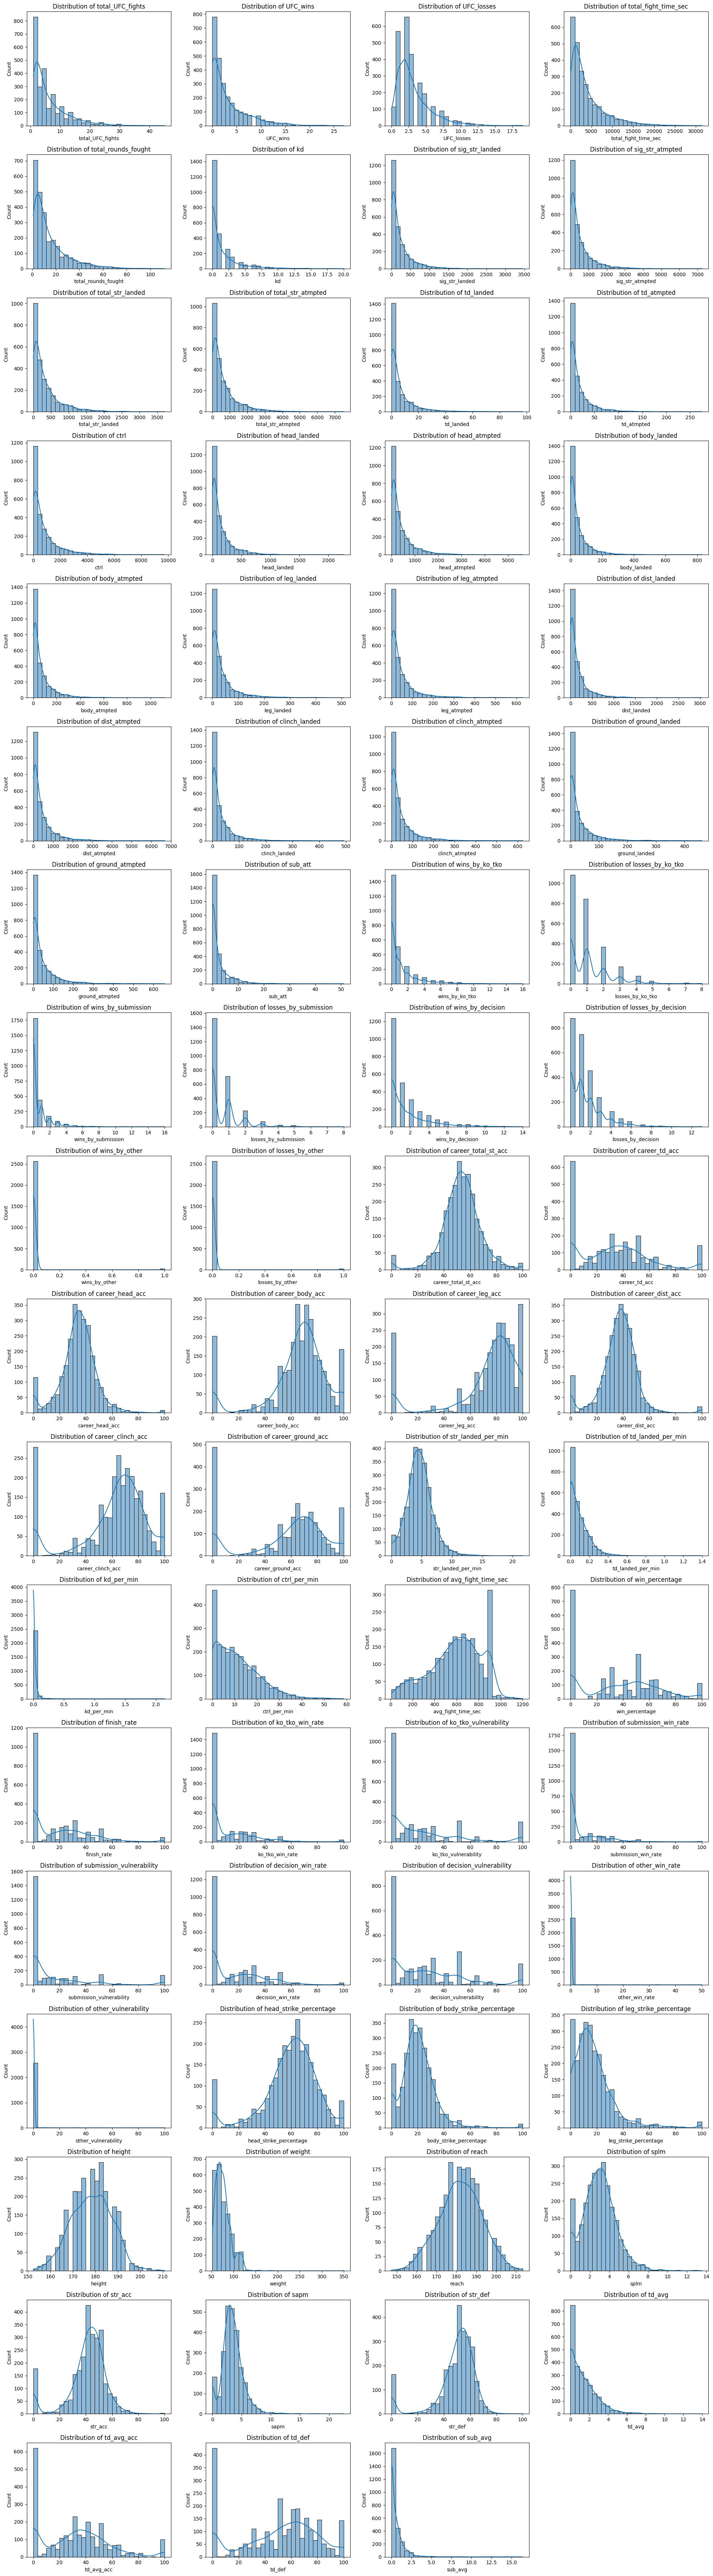

In [8]:
# Select numeric columns for distribution visualization
numeric_cols = df.select_dtypes(include=['number']).columns

# Set up the grid for subplots
num_cols = len(numeric_cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)  # Creates a grid with up to 4 plots per row

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Basic Cleaning and filtering

In [9]:
# Drill down on weight class 
df['division'].value_counts() # 89 unique weight classes # Need to consolidate these into standard weight classes

# Print all unique weight classes
# print(df['division'].unique())

division
lightweight                                                411
welterweight                                               403
middleweight                                               322
heavyweight                                                251
featherweight                                              231
                                                          ... 
ultimate fighter latin america 3 lightweight tournament      1
super heavyweight                                            1
14 heavyweight tournament                                    1
8 tournament                                                 1
ultimate fighter 18 women's bantamweight tournament          1
Name: count, Length: 89, dtype: int64

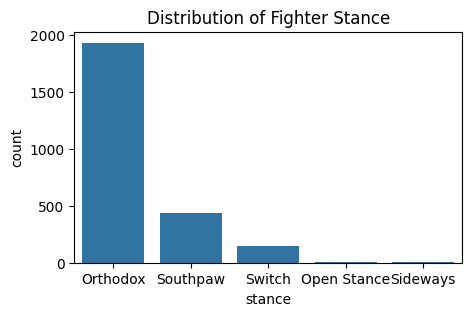

In [10]:
# visualize stance distribution
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='stance', order=df['stance'].value_counts().index)
plt.title('Distribution of Fighter Stance');

In [11]:
# Reclassify southpaw and switch stances as orthodox for simplicity
df['stance'] = df['stance'].replace({'Open Stance':'Orthodox', 'Sideways':'Orthodox'})

In [12]:
# Infer weight class from text

# Defene weight class mapping
def parse_weight_class(division):
    if pd.isna(division):
        return 'Unknown'
    division = division.lower()
    if "women" in division or "woman" in division:
        if "flyweight" in division:
            return "Women's Flyweight"
        elif "bantamweight" in division:
            return "Women's Bantamweight"
        elif "featherweight" in division:
            return "Women's Featherweight"
        elif "strawweight" in division:
            return "Women's Strawweight"
        else:
            return "Unknown"
    else:
        if "flyweight" in division:
            return "Flyweight"
        elif "bantamweight" in division:
            return "Bantamweight"
        elif "featherweight" in division:
            return "Featherweight"
        elif "lightweight" in division:
            return "Lightweight"
        elif "welterweight" in division:
            return "Welterweight"
        elif "middleweight" in division:
            return "Middleweight"
        elif "light heavyweight" in division:
            return "Light Heavyweight"
        elif "heavyweight" in division:
            return "Heavyweight"
        else:
            return "Unknown"

In [13]:
# infer weight class from weight_kg where possible
def infer_weight_class(row):
    if row['parsed_weight_class'] != 'Unknown':
        return row['parsed_weight_class']
    
    # This approach may misclassify some women fighters, but it's a reasonable assumption given the data    
    weight = row['weight']
    if pd.isna(weight):
        return 'Unknown'
    if weight <= 52.2:
        return "Women's Strawweight"
    elif weight <= 56.7:
        return "Flyweight"
    elif weight <= 61.2:
        return "Bantamweight"
    elif weight <= 65.8:
        return "Featherweight"
    elif weight <= 70.3:
        return "Lightweight"
    elif weight <= 77.1:
        return "Welterweight"
    elif weight <= 83.9:
        return "Middleweight"
    elif weight <= 93.0:
        return "Light Heavyweight"
    elif weight <= 120.2:
        return "Heavyweight"
    else:
        return "Catchweight"

In [14]:
df['parsed_weight_class'] = df['division'].apply(parse_weight_class)

df['weight_class'] = df.apply(infer_weight_class, axis=1)
print(df['weight_class'].value_counts())

weight_class
Lightweight              426
Welterweight             424
Middleweight             344
Heavyweight              304
Featherweight            250
Bantamweight             229
Light Heavyweight        225
Flyweight                120
Women's Strawweight       99
Women's Bantamweight      75
Women's Flyweight         63
Women's Featherweight     11
Catchweight               11
Unknown                   10
Name: count, dtype: int64


In [15]:
# Sitll have some Unknowns, print them out to see if we can improve further
df[['name','division', 'weight','total_UFC_fights']].loc[df['weight_class'] == 'Unknown']
# Fighters with no weight or division info, cannot infer weight class 

# Very few instances, can drop these if needed

,name,division,weight,total_UFC_fights
305,Sam Fulton,open weight,NaN,2
355,Jack McGlaughlin,open weight,NaN,1
645,He-Man Gipson,open weight,NaN,1
859,Jack Nilson,open weight,NaN,2
1097,Felix Lee Mitchell,open weight,NaN,3
1822,Dave Berry,open weight,NaN,1
1978,Frank Hamaker,open weight,NaN,1
2162,Francesco Maturi,open weight,NaN,1
2347,John Dowdy,open weight,NaN,1
2377,Ray Wizard,open weight,NaN,1


### Steps Taken
1. Infered weight class from weight
2. Dropped fighters with unknown weight
3. Reclassified fighters into either Orthodox, Southpaw, or Switch

## Data Quality and Validation

In [16]:
# Check for impossible values in dataset
df[['name','UFC_wins',
     'UFC_losses', 
     'total_UFC_fights',
       'wins_by_other']].loc[df['UFC_losses'] + df['UFC_wins'] != df['total_UFC_fights']]

,name,UFC_wins,UFC_losses,total_UFC_fights,wins_by_other


In [17]:
# Sanity check on a few well known fighters
df[['name', 'UFC_wins','total_UFC_fights',
                         'UFC_losses']].loc[df['name'] == 'Dustin Poirier'].T

,32
name,Dustin Poirier
UFC_wins,22
total_UFC_fights,30
UFC_losses,8


In [18]:
# Check if ctrl time is greater than match time
df[['name', 'ctrl', 'total_fight_time_sec']].loc[df['ctrl'] > df['total_fight_time_sec']]

,name,ctrl,total_fight_time_sec


In [19]:
# check for accuracy greater than 100%
acc_cols = [col for col in df.columns if 'acc'in col or 'rate' in col]

for col in acc_cols:
    if (df[col] > 100).any():
        print(f"Column {col} has values greater than 100%") # No columns have values greater than 100%

In [20]:
# Check if any fighters have no wins and no losses
# df.loc[(df['UFC_wins'] == 0) & (df['UFC_losses'] == 0)]# No fighters with no wins and no losses

In [21]:
# Check for fighters with negative values in any numeric columns
# negative_values = df[numeric_cols].lt(0).any(axis=1)
# df[negative_values] # No fighters with negative values in any numeric columns

In [22]:
# Find any errors in attempted vs landed significant strikes
attempted_cols = [col for col in df.columns if 'atmpted' in col]
landed_cols = [col.replace('atmpted', 'landed') for col in attempted_cols]

for atmpted_col, landed_col in zip(attempted_cols, landed_cols):
    if (df[landed_col] > df[atmpted_col]).any():
        print(f"Data error: {landed_col} has values greater than {atmpted_col}")
    else:
        print(f"No errors in {landed_col} vs {atmpted_col}")

No errors in sig_str_landed vs sig_str_atmpted
No errors in total_str_landed vs total_str_atmpted
No errors in td_landed vs td_atmpted
No errors in head_landed vs head_atmpted
No errors in body_landed vs body_atmpted
No errors in leg_landed vs leg_atmpted
No errors in dist_landed vs dist_atmpted
No errors in clinch_landed vs clinch_atmpted
No errors in ground_landed vs ground_atmpted


In [23]:
def validate_column(df, cols):
    for col in cols:
        if df[col].isnull().any():
            print(f"Column {col} has {df[col].isnull().sum()} missing values")
        if (df[col] == 0).any():
            print(f"Column {col} has {df[col].lt(1).sum()} zero values")

In [24]:
# Look for issues in key numeric columns

# Some key columns are reasonable to have zero values, but we should check them anyway

key_numeric_cols = ['total_fight_time_sec', 'total_rounds_fought', 'sig_str_landed',
       'sig_str_atmpted', 'total_str_landed', 'total_str_atmpted',
       'head_landed', 'head_atmpted', 'body_landed',
       'body_atmpted', 'leg_landed', 'leg_atmpted', 'dist_landed',
       'dist_atmpted', 'clinch_landed', 'clinch_atmpted', 'ground_landed',
       'ground_atmpted']

validate_column(df, key_numeric_cols)

Column sig_str_landed has 69 zero values
Column sig_str_atmpted has 38 zero values
Column total_str_landed has 43 zero values
Column total_str_atmpted has 28 zero values
Column head_landed has 115 zero values
Column head_atmpted has 54 zero values
Column body_landed has 202 zero values
Column body_atmpted has 157 zero values
Column leg_landed has 242 zero values
Column leg_atmpted has 203 zero values
Column dist_landed has 122 zero values
Column dist_atmpted has 52 zero values
Column clinch_landed has 278 zero values
Column clinch_atmpted has 213 zero values
Column ground_landed has 488 zero values
Column ground_atmpted has 419 zero values


In [43]:
# Zero in on fighters with no significant strikes landed
df.loc[df['total_str_atmpted'] == 0].total_UFC_fights.describe()

count    28.000000
mean      1.071429
std       0.262265
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: total_UFC_fights, dtype: float64

In [44]:
# Zero in on fighters with no significant strikes landed
df.loc[df['total_str_atmpted'] == 1][key_numeric_cols].head()

,total_fight_time_sec,total_rounds_fought,sig_str_landed,sig_str_atmpted,total_str_landed,total_str_atmpted,head_landed,head_atmpted,body_landed,body_atmpted,leg_landed,leg_atmpted,dist_landed,dist_atmpted,clinch_landed,clinch_atmpted,ground_landed,ground_atmpted
518,51,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
543,123,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
565,16,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
646,283,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1137,43,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It might make sense for certain metrics such as submissions, takedowns or control time to be 0 for strikers, but it seems very unliekly that there would be ever a case where a fighter has a fight with no strikes landed

Given that if a fighter as 0 total strikes landed, they should have 0 head, body, etc. strikes landed. This is not the case. Meaning total strikes attempted and landed is off.

Remake sig. strikes landed + attempted. Must recalc strike accuarcy metrics

38 fighters with zero significant strikes attempted in recalculated column, down from 713 in original column
No well known fighters, likely data entry errors or fighters with very few UFC fights
Can drop these rows if needed

In [25]:
validate_column(df, ['statmpted_v2', 'stlanded_v2']) 

df.loc[df['stlanded_v2'] == 0, ['name'] + key_numeric_cols].head()

Column statmpted_v2 has 38 zero values
Column stlanded_v2 has 69 zero values


,name,total_fight_time_sec,total_rounds_fought,sig_stlanded,sig_statmpted,total_stlanded,total_statmpted,head_landed,head_atmpted,body_landed,body_atmpted,leg_landed,leg_atmpted,dist_landed,dist_atmpted,clinch_landed,clinch_atmpted,ground_landed,ground_atmpted
34,Rudyard Moncayo,68,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,Trent Jenkins,329,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,Gerald Strebendt,165,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,Enson Inoue,96,1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151,Sam Adkins,704,5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [26]:
# Drop fighters with no significant strikes landed or attempted
df = df[(df['stlanded_v2'] > 0) & (df['statmpted_v2'] > 0)]

### Steps Taken

1. Created new significant strikes attempted and landed column
2. Need to recalc total strikes per minute
3. Drop Fighters with 0 signifcant strikes attempted

## Missing Values Assesment

In [27]:
# count missing values per column
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts 

# Need to filter or impute very important variables - stance, reach, height - most likely to be important for clustering

nick_name    858
reach        581
dob          112
stance        53
height        11
weight         8
dtype: int64

## Fight minimums

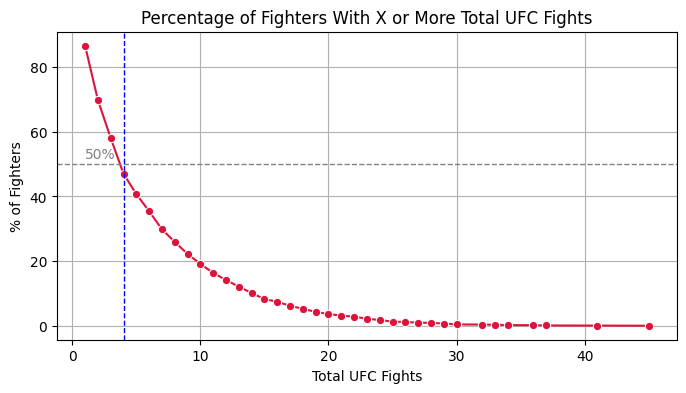

In [28]:
# Calculate the inverse cumulative percentage correctly
fight_counts = df['total_UFC_fights'].value_counts().sort_index()
cumulative_pct = fight_counts.cumsum() / len(df) * 100
inverse_cumulative_pct = 100 - cumulative_pct

plt.figure(figsize=(8,4))
sns.lineplot(x=inverse_cumulative_pct.index, y=inverse_cumulative_pct.values, marker='o', color='crimson')
plt.xlabel('Total UFC Fights')
plt.ylabel('% of Fighters')
plt.title('Percentage of Fighters With X or More Total UFC Fights')
plt.grid(True)

# Add a horizontal line at 50%
plt.axhline(50, color='gray', linestyle='--', linewidth=1)
plt.text(inverse_cumulative_pct.index.min(), 51, '50%', color='gray', va='bottom')

# Add a vertical line where 50% fall under x number of fights
if (inverse_cumulative_pct <= 50).any():
    x_50 = inverse_cumulative_pct[inverse_cumulative_pct <= 50].index[0]
    plt.axvline(x_50, color='blue', linestyle='--', linewidth=1)

plt.show()

In [29]:
# Filter for fighters with at least 5 UFC fights
df_filtered = df[df['total_UFC_fights'] >= 4]
df_filtered.shape # (1465, 83)

(1464, 82)

In [33]:
key_numeric_cols = ['total_fight_time_sec', 'stlanded_v2', 'statmpted_v2',
        'total_rounds_fought', 'sig_stlanded',
       'sig_statmpted', 'total_stlanded', 'total_statmpted',
       'head_landed', 'head_atmpted', 'body_landed',
       'body_atmpted', 'leg_landed', 'leg_atmpted', 'dist_landed',
       'dist_atmpted', 'clinch_landed', 'clinch_atmpted', 'ground_landed',
       'ground_atmpted']

In [ ]:
# Check for zero values in key numeric columns
validate_column(df_filtered, key_numeric_cols) 

Column sig_stlanded has 71 zero values
Column sig_statmpted has 65 zero values
Column total_stlanded has 67 zero values
Column total_statmpted has 65 zero values
Column head_landed has 1 zero values
Column head_atmpted has 1 zero values
Column body_landed has 3 zero values
Column body_atmpted has 2 zero values
Column leg_landed has 12 zero values
Column leg_atmpted has 8 zero values
Column dist_landed has 1 zero values
Column clinch_landed has 13 zero values
Column clinch_atmpted has 5 zero values
Column ground_landed has 26 zero values
Column ground_atmpted has 17 zero values


Results are acceptable -- Drop sig_stlanded, sig_statmpted, and total strikes in favor of new calc

Need to recalc this in data cleaning step, before aggregation -> then drop zero values in cleaning step

In [35]:
validate_column(df_filtered, ['reach', 'height', 'weight', 'stance'])

Column reach has 54 missing values


In [38]:
df_filtered['weight_class'].value_counts()

weight_class
Lightweight             234
Welterweight            228
Middleweight            199
Featherweight           156
Heavyweight             146
Bantamweight            132
Light Heavyweight       122
Flyweight                76
Women's Strawweight      68
Women's Bantamweight     49
Women's Flyweight        45
Name: count, dtype: int64

In [ ]:
# Drop catchweight and unknown weight classes for clustering
df_filtered = df_filtered[~df_filtered['weight_class'].isin(['Catchweight', 'Unknown', "Women's Featherweight"])]

### Steps Taken

1. Filter out fighters with less than 4 fights
2. Drop Catchweight fighters,women's feather weight, or unknown weight class

# Remove Outliers

In [39]:
df_filtered.columns

Index(['id', 'total_UFC_fights', 'UFC_wins', 'UFC_losses',
       'total_fight_time_sec', 'total_rounds_fought', 'kd', 'sig_stlanded',
       'sig_statmpted', 'total_stlanded', 'total_statmpted', 'td_landed',
       'td_atmpted', 'ctrl', 'head_landed', 'head_atmpted', 'body_landed',
       'body_atmpted', 'leg_landed', 'leg_atmpted', 'dist_landed',
       'dist_atmpted', 'clinch_landed', 'clinch_atmpted', 'ground_landed',
       'ground_atmpted', 'suatt', 'name', 'division', 'wins_by_ko_tko',
       'losses_by_ko_tko', 'wins_by_submission', 'losses_by_submission',
       'wins_by_decision', 'losses_by_decision', 'wins_by_other',
       'losses_by_other', 'career_sig_st_acc', 'career_total_st_acc',
       'career_td_acc', 'career_head_acc', 'career_body_acc', 'career_leg_acc',
       'career_dist_acc', 'career_clinch_acc', 'career_ground_acc',
       'sig_st_landed_per_min', 'td_landed_per_min', 'kd_per_min',
       'ctrl_per_min', 'avg_fight_time_sec', 'win_percentage', 'finish_rate',


# Data Imputation

In [ ]:
# Data imputing strategy

# Only missing reach - impute with median reach by weight class
reach_medians = df_filtered.groupby('standard_weight_class_v2')['reach'].median()
def impute_reach(row):
    if pd.isna(row['reach']):
        return reach_medians.get(row['standard_weight_class_v2'], df_filtered['reach'].median())
    return row['reach']

In [97]:
df_filtered = df_filtered.copy()  # Make sure it's a copy, not a view
df_filtered['reach'] = df_filtered.apply(impute_reach, axis=1)

In [1]:
# count missing values per column
missing_counts = df_filtered.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts 

NameError: name 'df_filtered' is not defined

### Steps Taken

1. Impute reach with median for weight class
2. 